# 1. Utils

In [1]:
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
import torchaudio.functional as FA
import torchaudio.transforms as T
import torchlibrosa as TL
from IPython import display as display_
import pandas as pd


from spotter.models import SimpleClassifier, MatchBox
from api.model import BiometryModel, ConvEncoder, Discriminator


with open('./spotter/models/id2number.pkl', 'rb') as f:
    id2number = pickle.load(f)
    
with open('./spotter/models/number2id.pkl', 'rb') as f:
    number2id = pickle.load(f)
    
UNK = "UNK"
UNK_CLASS = 0
assert id2number[UNK] == UNK_CLASS 
assert number2id[UNK_CLASS] == UNK    


def log_melspec_from_filename(
    filename = '/home/sergei/git/spotter-biometry-project/data/sda-project-set/audio/ffff91405b0f5b466b4f4b1fad5415d3.wav',
):
    waveform, sample_rate = torchaudio.load(filename)
    mel_spectrogram_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
    )

    melspec = mel_spectrogram_transform(waveform)
    min_val = 1e-5
    log_melspec = torch.log(torch.clamp(melspec, min_val))
    display_.display(display_.Audio(waveform[0], rate=sample_rate))

    print(log_melspec.shape)
    return log_melspec


def preprocessing(self, filename):
    transforms = nn.Sequential(
        TL.Spectrogram(
            n_fft=1024,
            hop_length=320,
        ),
        TL.LogmelFilterBank(
            sr=self.resample_rate,
            n_mels=128,
            n_fft=1024,
            fmin=20,
            fmax=16000,
        )
    )

    waveform_treshold = 200000
    waveform, sample_rate = torchaudio.load(filename, normalize=True)

    resampled_waveform = FA.resample(waveform,
                                     sample_rate,
                                     self.resample_rate)

    if resampled_waveform.shape[1] >= waveform_treshold:
        resampled_waveform = resampled_waveform[:, :waveform_treshold]
    else:
        resampled_waveform = F.pad(
            resampled_waveform,
            (0, waveform_treshold - resampled_waveform.shape[1], 0, 0),
            value=resampled_waveform.min()
        )

    resampled_waveform = transforms(resampled_waveform)

    return resampled_waveform

# 2. Models

## 2.1. Biometry

In [2]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.functional as FA
import torchaudio.transforms as TA
import torchlibrosa as TL

from api.model import BiometryModel, ConvEncoder, Discriminator
from api.config import *


class BiometryService:
    def __init__(self, checkpoint_path, model_treshold, resample_rate=32000, waveform_treshold=200000):
        self.model = BiometryModel.load_from_checkpoint(
            checkpoint_path,
            encoder=ConvEncoder(in_time=626, in_features=128, embedding_size=256),
            discriminator=Discriminator(input_size=256, d_size=200, hidden_size=256,
                                        negative_slope=0.2, use_cos=True, use_net=True)
        )
        self.model.eval()
        self.resample_rate = resample_rate
        self.waveform_treshold = waveform_treshold
        self.transforms = nn.Sequential(
            TL.Spectrogram(
                n_fft=1024,
                hop_length=320,
            ), TL.LogmelFilterBank(
                sr=self.resample_rate,
                n_mels=128,
                n_fft=1024,
                fmin=20,
                fmax=16000,
            )
        )
        self.model_treshold = model_treshold

    def preprocessing(self, filename):
        waveform, sample_rate = torchaudio.load(filename, normalize=True)

        resampled_waveform = FA.resample(waveform,
                                         sample_rate,
                                         self.resample_rate)

        if resampled_waveform.shape[1] >= self.waveform_treshold:
            resampled_waveform = resampled_waveform[:, :self.waveform_treshold]
        else:
            resampled_waveform = F.pad(
                resampled_waveform,
                (0, self.waveform_treshold - resampled_waveform.shape[1], 0, 0),
                value=resampled_waveform.min()
            )

        if self.transforms is not None:
            resampled_waveform = self.transforms(resampled_waveform)

        return resampled_waveform

    def set_specimen_d_vector(self):
        spec_records_paths = glob.glob(f'{os.path.join(DIRECTORY_SAMPELS, TEMPLATE_NAME_EXAMPLES_VOICE.format("*"))}')
        spec_X = torch.cat([self.preprocessing(spec_records_path) for spec_records_path in spec_records_paths], dim=0)

        with torch.no_grad():
            self.model.set_specimen_d_vector(spec_X)

    def predict(self):
        x = self.preprocessing(os.path.join(DIRECTORY_SAMPELS, TEMPLATE_REC_VOICE))

        with torch.no_grad():
            return int(self.model(x) > self.model_treshold)

In [3]:
%%time
biom = BiometryService('/home/sergei/git/spotter-biometry-project/checkpoints/biometry_model.ckpt', -3)

PERSON = '3_2392'

df = pd.read_csv('/home/sergei/git/spotter-biometry-project/data/sda-project-set/data.tsv', sep='\t')
paths_3 = df[df['speaker_id'] == PERSON]['name'].tolist()
audio_dir = Path('/home/sergei/git/spotter-biometry-project/data/sda-project-set/audio/')
paths_3 = list(map(lambda x: audio_dir / x, paths_3))
spec_X = torch.cat(
    [biom.preprocessing(spec_records_path) for spec_records_path in paths_3[:20]],
    dim=0,
)
biom.model.set_specimen_d_vector(spec_X)

/home/sergei/anaconda3/lib/python3.8/site-packages/torchlibrosa/stft.py:193: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = librosa.util.pad_center(fft_window, n_fft)


CPU times: user 19.8 s, sys: 1.81 s, total: 21.6 s
Wall time: 2.96 s


## 2.2. Spotter

In [4]:
spotter = MatchBox()  #SimpleClassifier()

spotter_ckpt = torch.load('checkpoints/MatchBox_3_1_64_Vol.pth')
spotter.load_state_dict(spotter_ckpt)

<All keys matched successfully>

In [5]:
def spotter_inf(filename, PRED):
    if True: #here we can change the condition
        x = biom.preprocessing(filename)

        with torch.no_grad():
            if biom.model(x).item() > biom.model_treshold:
                print('>>> OOOOOOOOOOOOOOK', PERSON)
            else:
                print(f'>>> NOTNOTNOTNOTNOT {PERSON}')
            print('Prob and threshold:', biom.model(x).item(), biom.model_treshold)


    waveform, sample_rate = torchaudio.load(filename)
    display_.display(display_.Audio(waveform[0], rate=sample_rate))

    mel_spectrogram_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
    )
    
    ANS = number2id[PRED]
    
    win_size = sample_rate // 2
    skip = sample_rate // 10

    res = []
    res2 = []
    
    for i in range(0, waveform.shape[1] - win_size, skip):
        #win = log_melspec#log_melspec[:, :, i:i+win_size]
        win_waveform = waveform[:, i:i+win_size]

        melspec = mel_spectrogram_transform(win_waveform)
        min_val = 1e-5
        log_melspec = torch.log(torch.clamp(melspec, min_val))
        #display_.display(display_.Audio(waveform[0], rate=sample_rate))

        probs = spotter.forward(log_melspec)
        probs = torch.softmax(probs, dim=1)

        res.append(probs[0][PRED])
        res2.append(probs[0][20])

        
    res = list(map(lambda x: x.detach().numpy(), res))
    res2 = list(map(lambda x: x.detach().numpy(), res2))

    plt.plot(np.arange(0, waveform.shape[1] - win_size, skip), res, color='b')
    plt.plot(np.arange(0, waveform.shape[1] - win_size, skip), res2, color='r')
    plt.show()


    return PRED, ANS, res, res2

# 3. Inference

In [6]:
df.head(8)

,name,text,speaker_id,record_id
0,d58d933684488a856ff42022d5027347.wav,назад,3_2392,896676c2-35db-46bb-b462-56824cdd444d
1,d683c6e62cca6557c594d6353aa3da79.wav,заново,2_2204,431b44d9-8283-47a9-a0e8-b99e51a9bdd5
2,240fad4784d93f467f927edb2eb783bf.wav,включи веселую музыку,3_2379,11266c29-55b5-4f53-8094-5cec3ec761f0
3,5f9e6c9d6fd8edc29735abd17e68470b.wav,здравствуй,3_2389,f5eda328-9ccd-4c27-af8b-1d56dfe6d835
4,0cf4c0784b2e6b006106e24ca159c8cb.wav,нормально,2_2226,4c245893-0dc3-4b13-b3ab-f0b28ce7d41e
5,a920ae8c8d162e334933e4e07f73e250.wav,какая погода на улице,3_2377,c8bc415f-6cab-4727-9593-3283f0af737c
6,8a5e6085bb77b751f71c3f1b525151cf.wav,выключи музыку,2_2174,ebbddd32-97d9-4488-998f-c9f50f6f7c69
7,93af6920a2f3198725fb2c34370a540d.wav,громкость шесть,2_2187,aa593be0-a72f-4825-b469-870f2d999b9f


[PosixPath('/home/sergei/git/spotter-biometry-project/data/sda-project-set/audio/d58d933684488a856ff42022d5027347.wav'), PosixPath('/home/sergei/git/spotter-biometry-project/data/sda-project-set/audio/d683c6e62cca6557c594d6353aa3da79.wav'), PosixPath('/home/sergei/git/spotter-biometry-project/data/sda-project-set/audio/240fad4784d93f467f927edb2eb783bf.wav')]
Current person: 3_2392
>>> OOOOOOOOOOOOOOK 3_2392
Prob and threshold: -2.832331657409668 -3


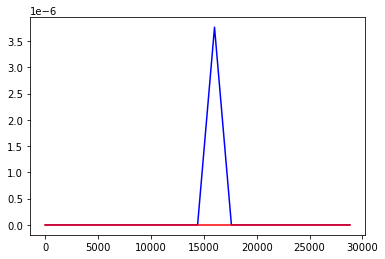

Word ID and word: 110 назад
Prob and other class prob: 3.7641564e-06 1.973143e-27
Current person: 2_2204
>>> NOTNOTNOTNOTNOT 3_2392
Prob and threshold: -4.536929130554199 -3


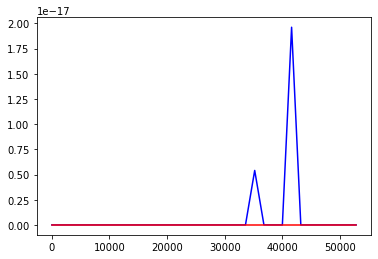

Word ID and word: 80 заново
Prob and other class prob: 1.9614762e-17 1.2399901e-37
Current person: 3_2379
>>> OOOOOOOOOOOOOOK 3_2392
Prob and threshold: -2.930814266204834 -3


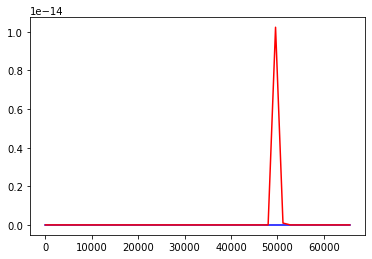

Word ID and word: 6 включи веселую музыку
Prob and other class prob: 2.8781467e-23 1.0238078e-14
Current person: 3_2389
>>> OOOOOOOOOOOOOOK 3_2392
Prob and threshold: -1.7979710102081299 -3


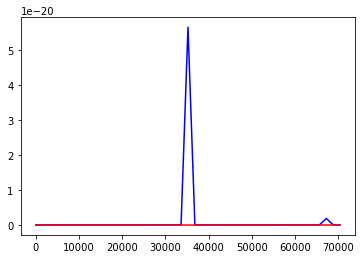

Word ID and word: 84 здравствуй
Prob and other class prob: 5.6598845e-20 0.0
Current person: 2_2226
>>> NOTNOTNOTNOTNOT 3_2392
Prob and threshold: -4.415981292724609 -3


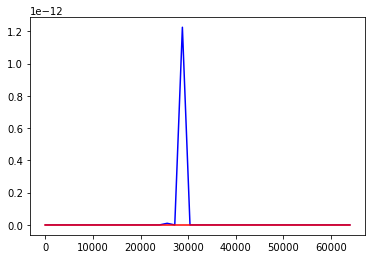

Word ID and word: 122 нормально
Prob and other class prob: 1.2255829e-12 5.4930034e-32
Current person: 3_2377
>>> NOTNOTNOTNOTNOT 3_2392
Prob and threshold: -6.39051628112793 -3


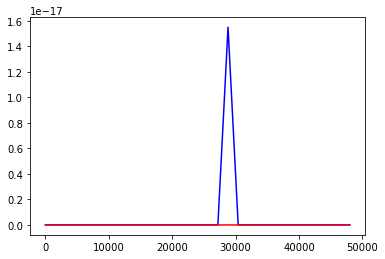

Word ID and word: 94 какая погода на улице
Prob and other class prob: 1.5506015e-17 8.1908955e-23
Current person: 2_2174
>>> NOTNOTNOTNOTNOT 3_2392
Prob and threshold: -3.3719916343688965 -3


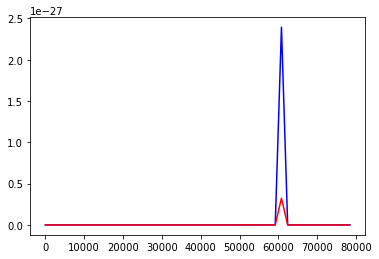

Word ID and word: 46 выключи музыку
Prob and other class prob: 2.392646e-27 3.230026e-28
Current person: 2_2187
>>> NOTNOTNOTNOTNOT 3_2392
Prob and threshold: -3.768859386444092 -3


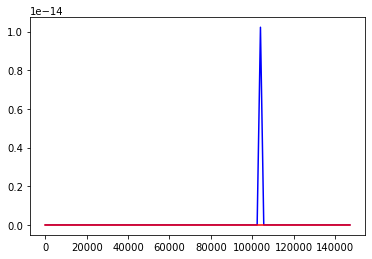

Word ID and word: 62 громкость шесть
Prob and other class prob: 1.0225439e-14 1.5385682e-22


In [7]:
paths = df.name.tolist()
paths = list(map(lambda x: audio_dir / x, paths))
texts = df.text.tolist()
labels = list(map(lambda x: id2number[x], texts))
person_indices = df.speaker_id.tolist()
print(paths[:3])
log_melspecs = list()

for i, p in enumerate(paths):
    if i < 8:
        print('Current person:', person_indices[i])
        num, word, res, res2 = spotter_inf(p, labels[i])
        print('Word ID and word:', num, word)
        print('Prob and other class prob:', max(res), max(res2))
        print('================')

# 3.2. Wild data

>>> OOOOOOOOOOOOOOK 3_2392
Prob and threshold: -2.593761682510376 -3


/home/sergei/.local/lib/python3.8/site-packages/torchaudio/functional/functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


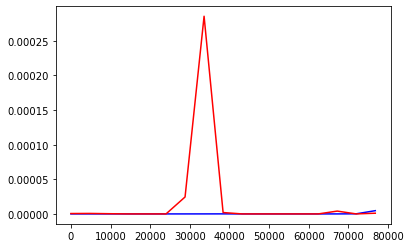

In [8]:
num, word, res, res2 = spotter_inf('/home/sergei/svet.wav', id2number['свет'])

>>> OOOOOOOOOOOOOOK 3_2392
Prob and threshold: -2.7494351863861084 -3


/home/sergei/.local/lib/python3.8/site-packages/torchaudio/functional/functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


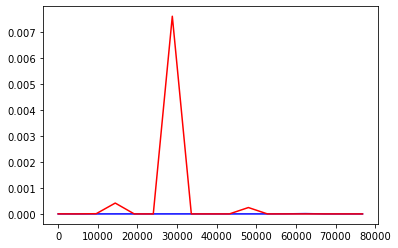

In [9]:
num, word, res, res2 = spotter_inf('/home/sergei/nazad.wav', id2number['назад'])

# 4. Biometry Pure API

In [10]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.functional as FA
import torchaudio.transforms as TA
import torchlibrosa as TL

from api.model import BiometryModel, ConvEncoder, Discriminator
from api.config import *


class BiometryService:
    def __init__(self, checkpoint_path, model_treshold, resample_rate=32000, waveform_treshold=200000):
        self.model = BiometryModel.load_from_checkpoint(
            checkpoint_path,
            encoder=ConvEncoder(in_time=626, in_features=128, embedding_size=256),
            discriminator=Discriminator(input_size=256, d_size=200, hidden_size=256,
                                        negative_slope=0.2, use_cos=True, use_net=True)
        )
        self.model.eval()
        self.resample_rate = resample_rate
        self.waveform_treshold = waveform_treshold
        self.transforms = nn.Sequential(
            TL.Spectrogram(
                n_fft=1024,
                hop_length=320,
            ), TL.LogmelFilterBank(
                sr=self.resample_rate,
                n_mels=128,
                n_fft=1024,
                fmin=20,
                fmax=16000,
            )
        )
        self.model_treshold = model_treshold

    def preprocessing(self, filename):
        waveform, sample_rate = torchaudio.load(filename, normalize=True)

        resampled_waveform = FA.resample(waveform,
                                         sample_rate,
                                         self.resample_rate)

        if resampled_waveform.shape[1] >= self.waveform_treshold:
            resampled_waveform = resampled_waveform[:, :self.waveform_treshold]
        else:
            resampled_waveform = F.pad(
                resampled_waveform,
                (0, self.waveform_treshold - resampled_waveform.shape[1], 0, 0),
                value=resampled_waveform.min()
            )

        if self.transforms is not None:
            resampled_waveform = self.transforms(resampled_waveform)

        return resampled_waveform

    def set_specimen_d_vector(self):
        spec_records_paths = glob.glob(f'{os.path.join(DIRECTORY_SAMPELS, TEMPLATE_NAME_EXAMPLES_VOICE.format("*"))}')
        spec_X = torch.cat([self.preprocessing(spec_records_path) for spec_records_path in spec_records_paths], dim=0)

        with torch.no_grad():
            self.model.set_specimen_d_vector(spec_X)

    def predict(self):
        x = self.preprocessing(os.path.join(DIRECTORY_SAMPELS, TEMPLATE_REC_VOICE))

        with torch.no_grad():
            return int(self.model(x) > self.model_treshold)

In [11]:
biom = BiometryService('/home/sergei/git/spotter-biometry-project/checkpoints/biometry_model.ckpt', -3)

/home/sergei/anaconda3/lib/python3.8/site-packages/torchlibrosa/stft.py:193: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = librosa.util.pad_center(fft_window, n_fft)


In [12]:
paths_3 = df[df['speaker_id'] == '3_2392']['name'].tolist()
audio_dir = Path('/home/sergei/git/spotter-biometry-project/data/sda-project-set/audio/')
paths_3 = list(map(lambda x: audio_dir / x, paths_3))
spec_X = torch.cat(
    [biom.preprocessing(spec_records_path) for spec_records_path in paths_3[:10]],
    dim=0,
)

In [13]:
%%time
biom.model.set_specimen_d_vector(spec_X)

CPU times: user 7.35 s, sys: 764 ms, total: 8.12 s
Wall time: 1.02 s


In [14]:
for i in range(10, 20):
    filename = paths_3[i]
    x = biom.preprocessing(filename)

    with torch.no_grad():
        print(biom.model(x).item(), biom.model_treshold)

-2.082521438598633 -3
-0.8761640787124634 -3
-0.9718669056892395 -3
-1.7770178318023682 -3
-2.037226915359497 -3
-2.425974130630493 -3
-9.55140495300293 -3
-3.681366205215454 -3
-1.8159325122833252 -3
-1.8598289489746094 -3


In [15]:
paths_not3 = df[df['speaker_id'] != '3_2392']['name'].tolist()
audio_dir = Path('/home/sergei/git/spotter-biometry-project/data/sda-project-set/audio/')
paths_not3 = list(map(lambda x: audio_dir / x, paths_not3))
len(paths_not3)

105821

In [16]:
for i in range(10, 20):
    filename = paths_not3[i]
    x = biom.preprocessing(filename)

    with torch.no_grad():
        print(biom.model(x).item(), biom.model_treshold)

-3.613832473754883 -3
-4.326939582824707 -3
-1.5639119148254395 -3
-4.436509132385254 -3
-4.111644268035889 -3
-5.501496315002441 -3
-4.611218452453613 -3
-9.017294883728027 -3
-2.3752830028533936 -3
-4.350720405578613 -3
